In [1]:
import numpy as np
import xroms
from glob import glob
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import sys
import xrft
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle

from dask.diagnostics import ProgressBar
import dask
from dask.distributed import Client, LocalCluster

import scipy.integrate as integ
warnings.filterwarnings("ignore")
import seawater as sw


In [2]:

plt.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [3]:
client = Client(processes=False)
# client = Client(cluster)
# client = Client(n_workers=90)


In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://128.8.216.13:8787/status,
Dashboard: http://128.8.216.13:8787/status,Workers: 1
Total threads: 128,Total memory: 502.98 GiB
Status: running,Using processes: False
Comm: inproc://128.8.216.13/1933475/1,Workers: 1
Dashboard: http://128.8.216.13:8787/status,Total threads: 128
Started: Just now,Total memory: 502.98 GiB
Comm: inproc://128.8.216.13/1933475/4,Total threads: 128
Dashboard: http://128.8.216.13:41005/status,Memory: 502.98 GiB
Nanny: None,


In [5]:
# chunks={'time_counter':10, 'x_rho':50, 'y_rho':190,'s_rho':80,'s_w':80}
chunks={'time_counter':1,'x_rho':1000,"x_u":1000,"x_v":1000,
                        'y_rho':1520,"y_u":1520,"y_v":1520,'s_rho':80,'s_w':80}


path='/data/pacific/lrenault/SASI/CROCO/'

varf=xr.open_mfdataset(path + 'FULL/SASI*2012-01*.nc',data_vars='minimal',chunks=chunks)
vart=xr.open_mfdataset(path + 'SMTH/SASI*2012-01*.nc',data_vars='minimal',chunks=chunks)

# varf=xr.open_mfdataset(path + 'FULL/SASI*2012*.nc',data_vars='minimal',chunks=chunks)
# vart=xr.open_mfdataset(path + 'SMTH/SASI*2012*.nc',data_vars='minimal',chunks=chunks)

In [6]:
varx = varf.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v","x_w":"xi_w",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
df,gf=xroms.roms_dataset(varx,Vtransform=varx.Vtransform.data)

vary = vart.rename({"time_counter":"ocean_time","x_rho": "xi_rho","x_u":"xi_u","x_v":"xi_v",
                    "y_rho":"eta_rho","y_v":"eta_v","y_u":"eta_u","y_w":"eta_w","s_rho":"s_rho","s_w":"s_w"})
dt,gt=xroms.roms_dataset(vary,Vtransform=vary.Vtransform.data)

In [7]:
timer_h=pd.DatetimeIndex(dt.ocean_time)
timer_d=pd.DatetimeIndex(dt.ocean_time.groupby("ocean_time.dayofyear").mean())

In [10]:
# temp_full=df.temp[:,:,120:-120,120:700]
# temp_smth=dt.temp[:,:,120:-120,120:700]

# salt_full=df.salt[:,:,120:-120,120:700]
# salt_smth=dt.salt[:,:,120:-120,120:700]

In [11]:
# def xr_pden(s,t,p,pr):
#     return xr.apply_ufunc(sw.pden,kwargs={'t':t,'s':s,'p':p,'pr':pr})

In [12]:
%time
rho_full=df.rho[:,:,120:-120,120:700]+df.rho0
rho_smth=dt.rho[:,:,120:-120,120:700]+dt.rho0

# rho_full=temp_full[0].copy(data=sw.pden(s=salt_full[0,:],t=temp_full[0,:],p=-temp_full.z_rho[0,:],pr=0))
# rho_smth=temp_smth[0].copy(data=sw.pden(s=salt_smth[0,:],t=temp_smth[0,:],p=-temp_smth.z_rho[0,:],pr=0))

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 12.4 µs


In [13]:
# z_interp=np.linspace(-2,-100, 100)
z_interp=np.linspace(-2,-1000,100)
z_interp_rev=np.linspace(2,1000,100)[::-1]

np.diff(z_interp).mean()

-10.080808080808081

In [14]:
# z_matrix=np.zeros([z_interp.shape[0],rho_full.shape[2],rho_full.shape[3]])
z_matrix=np.zeros([z_interp.shape[0],rho_full.shape[1],rho_full.shape[2]])
z_matrix[:,:,:]=-z_interp[:,None,None]

In [153]:
dec=1
Zstar_full=xr.DataArray(coords=(df.ocean_time[::dec],
                                z_interp_rev,
                                rho_full.eta_rho.data,
                                rho_full.xi_rho.data),
                      dims=['ocean_time','z_rho','eta_rho','xi_rho'])

In [81]:
%%time
"NEW METHOD PT 1"
day_x=0
rho_full_interp=rho_full[:,:,:].xroms.isoslice(z_interp).compute()
rho_full_interp['z_rho']=z_interp_rev

"numpy method (working but janky)"
rho_full_stacked=np.ravel(rho_full_interp)
index_sorted_full=np.argsort(rho_full_stacked)

rho_star=rho_full_interp.copy(data=rho_full_stacked[index_sorted_full].reshape(rho_full_interp.shape))
rho_star_m=rho_full_interp.copy(data=np.tile(rho_star.mean(['xi_rho','eta_rho']),
                                             (rho_full_interp.shape[2],rho_full_interp.shape[1],1)).T)

CPU times: user 13.5 s, sys: 921 ms, total: 14.4 s
Wall time: 12.6 s


In [ ]:
%%time
'ZSTAR. new method: assuming that rho* is approx mean(rho*)'

for zi in range(z0.shape[0]):
    Zstar_full[day_x,zi,:,:]=z_interp_rev[(np.abs(rho_full_interp[zi,:,:]-rho_star_m)).argmin('z_rho')]

In [ ]:
"OLD  METHOD: numpy method (working but janky)"
rho_stacked=np.ravel(rho)
index_sorted=np.argsort(rho_stacked)

# rho_sorted=np.sort(rho_stacked)
# rho_star=rho_sorted.reshape(rho.shape)
rho_m=np.tile(np.nanmean(rho,axis=1),(x.shape[0],1)).T
rho_star=rho.copy(data=rho_stacked[index_sorted].reshape(rho.shape))
rho_star_m=rho.copy(data=np.tile(np.nanmean(rho_star,axis=1),(x.shape[0],1)).T)



In [28]:
day_x=0
rho_full_interp=rho_full[:,:,:].xroms.isoslice(z_interp).compute()

# rho_full_interp=rho_full[day_x,:,:,:].xroms.isoslice(z_interp).compute()
rho_full_interp['z_rho']=z_interp_rev

"numpy method (working but janky)"
rho_full_stacked=np.ravel(rho_full_interp)
index_sorted_full=np.argsort(rho_full_stacked)


z_full_stacked=np.ravel(z_matrix.copy())
# zstar_full[:]=z_full_stacked[index_sorted_full].reshape(rho_full_interp.shape)
Zstar_full[day_x,:,:,:]=z_full_stacked[index_sorted_full].reshape(rho_full_interp.shape)

In [26]:
dec=1
Zstar_full=xr.DataArray(coords=(df.ocean_time[::dec],
                                z_interp_rev,
                                rho_full.eta_rho.data,
                                rho_full.xi_rho.data),
                      dims=['ocean_time','z_rho','eta_rho','xi_rho'])

# Rho_full_interp=xr.DataArray(coords=(df.ocean_time[::dec],
#                                 z_interp_rev,
#                                 rho_full.eta_rho.data,
#                                 rho_full.xi_rho.data),
#                       dims=['ocean_time','z_rho','eta_rho','xi_rho'])


# Zstar_full=Zstar_full.to_dataset(name='z_star')
# Zstar_smth=Zstar_smth.to_dataset(name='z_star')

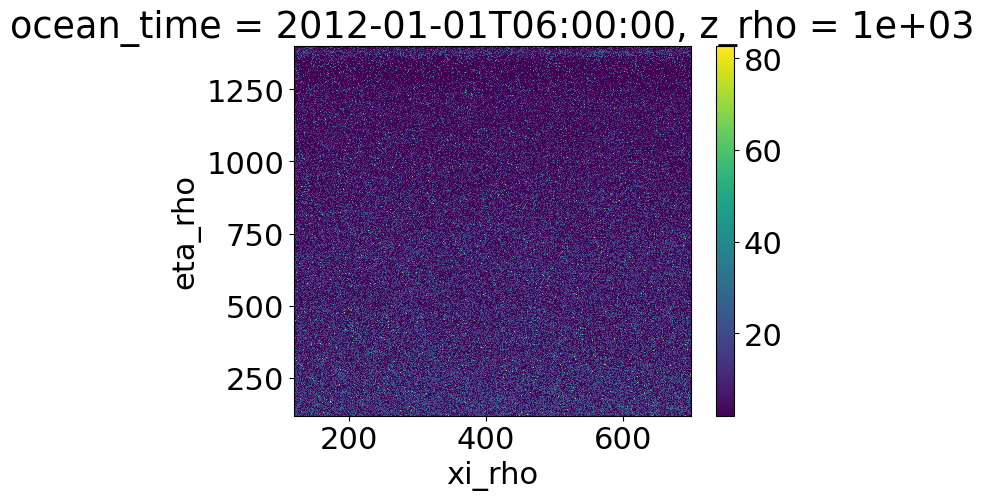

In [31]:
Zstar_full[0,-1].plot()

In [17]:
%%time
M='01'
# day_x=-1

for day_x in range(rho_full.ocean_time.shape[0]):

    rho_full_interp=rho_full[day_x,:,:,:].xroms.isoslice(z_interp).compute()
    # z_full_interp[:]=z_matrix.copy()
    Rho_full_interp[day_x,:,:,:]=rho_full_interp
    
    
    "numpy method (working but janky)"
    rho_full_stacked=np.ravel(rho_full_interp)
    index_sorted_full=np.argsort(rho_full_stacked)

    # rho_star=rho_stacked[index_sorted].reshape(rho.shape)

    z_full_stacked=np.ravel(z_matrix.copy())
    # zstar_full[:]=z_full_stacked[index_sorted_full].reshape(rho_full_interp.shape)
    Zstar_full[day_x,:,:,:]=z_full_stacked[index_sorted_full].reshape(rho_full_interp.shape)


CPU times: user 57min 47s, sys: 9min 45s, total: 1h 7min 33s
Wall time: 1h 13min 10s


In [18]:
%%time
Zstar_full.to_netcdf('/data/pacific/iufarias/z_star/z_star_full_M{0}.nc'.format(M))
del Zstar_full

CPU times: user 59.6 s, sys: 1min 4s, total: 2min 3s
Wall time: 23min 43s


In [19]:
%%time
Rho_full_interp.to_netcdf('/data/pacific/iufarias/z_star/rho_full_M{0}.nc'.format(M))
del Rho_full_interp

CPU times: user 41.8 s, sys: 1min 14s, total: 1min 56s
Wall time: 23min 8s


In [20]:
z_matrix=np.zeros([z_interp.shape[0],rho_smth.shape[2],rho_smth.shape[3]])
z_matrix[:,:,:]=z_interp[:,None,None]

z_smth_interp=rho_smth[0,:,:,:].xroms.isoslice(z_interp).copy().compute()
zstar_smth=rho_smth[0,:,:,:].xroms.isoslice(z_interp).copy().compute()
del zstar_smth.attrs['grid']


In [21]:
Zstar_smth=xr.DataArray(coords=(dt.ocean_time[::dec],
                                z_interp,
                                rho_smth.eta_rho,
                                rho_smth.xi_rho),
                      dims=['ocean_time','z_rho','eta_rho','xi_rho'])

Rho_smth_interp=xr.DataArray(coords=(dt.ocean_time[::dec],
                                z_interp,
                                rho_smth.eta_rho,
                                rho_smth.xi_rho),
                      dims=['ocean_time','z_rho','eta_rho','xi_rho'])


In [22]:
%%time
M='01'
# day_x=-1

for day_x in range(rho_smth.ocean_time.shape[0]):

    rho_smth_interp=rho_smth[day_x,:,:,:].xroms.isoslice(z_interp).compute()
    # z_full_interp[:]=z_matrix.copy()
    Rho_smth_interp[day_x,:,:,:]=rho_smth_interp

    "numpy method (working but janky)"
    rho_smth_stacked=np.ravel(rho_smth_interp)
    index_sorted_smth=np.argsort(rho_smth_stacked)

    # rho_star=rho_stacked[index_sorted].reshape(rho.shape)

    z_smth_stacked=np.ravel(z_matrix.copy())
    # zstar_full[:]=z_full_stacked[index_sorted_full].reshape(rho_full_interp.shape)
    Zstar_smth[day_x,:,:,:]=z_smth_stacked[index_sorted_smth].reshape(rho_smth_interp.shape)


CPU times: user 57min 55s, sys: 3min 57s, total: 1h 1min 52s
Wall time: 1h 7min 22s


In [23]:
%%time
Zstar_smth.to_netcdf('/data/pacific/iufarias/z_star/z_star_smth_M{0}.nc'.format(M))
del Zstar_smth

CPU times: user 1min 3s, sys: 1min 8s, total: 2min 12s
Wall time: 22min 59s


In [24]:
%%time
Rho_smth_interp.to_netcdf('/data/pacific/iufarias/z_star/rho_smth_M{0}.nc'.format(M))
del Rho_smth_interp

CPU times: user 47.8 s, sys: 1min 22s, total: 2min 10s
Wall time: 23min
